In [1]:
import os
import datetime
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
from typing import Tuple
from bisect import bisect_left, bisect_right


# Remux

In [101]:
dir = os.path.abspath("/mnt/c/Users/yiguo/Desktop/apixC_末日合集/footages/")
# dir = os.path.abspath("../recordings/")

command_list = []
for file in os.listdir(dir):
    if file.endswith(".flv"):
        command = "ffmpeg -i " + file + " -c:a copy -c:v copy " + file[:-3] + "mp4"
        command_list.append(command)


command_merged = "; ".join(command_list)
print(command_merged)


ffmpeg -i 47867_20220721_024552_猫猫模拟器.flv -c:a copy -c:v copy 47867_20220721_024552_猫猫模拟器.mp4; ffmpeg -i 92613_20220721_041919_末世生存第二季dlc.flv -c:a copy -c:v copy 92613_20220721_041919_末世生存第二季dlc.mp4; ffmpeg -i 92613_20220721_051202_末世生存第二季dlc.flv -c:a copy -c:v copy 92613_20220721_051202_末世生存第二季dlc.mp4


# Split Recording

In [56]:
# dir = os.path.abspath("../recordings") + "/"
dir = os.path.abspath("/mnt/c/Users/yiguo/Desktop/apixC_末日合集/footages/") + "/"
filename = "47867_20220801_020712_异度之刃3"
split_time = "03:09:44"


assert len(split_time) == 8
assert len(split_time.split(":")) == 3
tmp = split_time.split(":")
split_sec = 3600 * float(tmp[0]) + 60 * float(tmp[1]) + float(tmp[2])

recording_path = dir + filename + ".mp4"
xml_path = dir + filename + ".xml"
assert os.path.isfile(recording_path)
assert os.path.isfile(xml_path)


filename_part1 = filename + "_part1"
filename_part2 = filename + "_part2"
tmp = filename_part2.split("_", 3)
start_time = datetime.datetime.strptime("".join(tmp[1:3]), "%Y%m%d%H%M%S")
start_time_part2 = start_time + datetime.timedelta(seconds=split_sec)
filename_part2 = (
    tmp[0] + datetime.datetime.strftime(start_time_part2, "_%Y%m%d_%H%M%S_") + tmp[3]
)
recording_part1_path = dir + filename_part1 + ".mp4"
recording_part2_path = dir + filename_part2 + ".mp4"
xml_part1_path = dir + filename_part1 + ".xml"
xml_part2_path = dir + filename_part2 + ".xml"


print("Preparing to split")
print(recording_path)
print(xml_path)
print("at " + split_time)
print("Expecting to generate")
print(recording_part1_path)
print(xml_part1_path)
print(recording_part2_path)
print(xml_part2_path)


Preparing to split
/mnt/c/Users/yiguo/Desktop/apixC_末日合集/footages/47867_20220801_020712_异度之刃3.mp4
/mnt/c/Users/yiguo/Desktop/apixC_末日合集/footages/47867_20220801_020712_异度之刃3.xml
at 03:09:44
Expecting to generate
/mnt/c/Users/yiguo/Desktop/apixC_末日合集/footages/47867_20220801_020712_异度之刃3_part1.mp4
/mnt/c/Users/yiguo/Desktop/apixC_末日合集/footages/47867_20220801_020712_异度之刃3_part1.xml
/mnt/c/Users/yiguo/Desktop/apixC_末日合集/footages/47867_20220801_051656_异度之刃3_part2.mp4
/mnt/c/Users/yiguo/Desktop/apixC_末日合集/footages/47867_20220801_051656_异度之刃3_part2.xml


### Split Video

In [57]:
command_list = []
command_list.append(
    "ffmpeg -i "
    + filename
    + ".mp4 -to "
    + split_time
    + " -c:a copy -c:v copy "
    + filename_part1
    + ".mp4"
)
command_list.append(
    "ffmpeg -i "
    + filename
    + ".mp4 -ss "
    + split_time
    + " -c:a copy -c:v copy "
    + filename_part2
    + ".mp4"
)
if " " in filename:
    print("Please remove spaces in the filename")
else:
    print("; ".join(command_list))


ffmpeg -i 47867_20220801_020712_异度之刃3.mp4 -to 03:09:44 -c:a copy -c:v copy 47867_20220801_020712_异度之刃3_part1.mp4; ffmpeg -i 47867_20220801_020712_异度之刃3.mp4 -ss 03:09:44 -c:a copy -c:v copy 47867_20220801_051656_异度之刃3_part2.mp4


### Split Danmaku

In [58]:
def split_danmaku(xml_file: str, split_sec: float) -> Tuple[str, str]:
    part1, part2 = [], []

    for line in xml_file.split("\n"):
        if line.startswith("  <d") or line.startswith("  <sc"):
            # continue
            [seg1, tmp] = line.split('"', 1)
            seg1 += '"'
            [seg2, seg3] = tmp.split(".", 1)
            seg2 += "." + seg3[:3]
            seg3 = seg3[3:]

            danmaku_time = float(seg2)
            if danmaku_time < split_sec:
                part1.append(seg1 + f"{danmaku_time:.3f}" + seg3)
            else:
                danmaku_time -= split_sec
                part2.append(seg1 + f"{danmaku_time:.3f}" + seg3)
        elif line.startswith("  <BililiveRecorderRecordInfo"):
            # continue
            [seg1, tmp] = line.split('start_time="', 1)
            seg1 += 'start_time="'
            [seg2, seg3] = tmp.split('"', 1)
            seg3 = '"' + seg3
            start_time = datetime.datetime.strptime(seg2[:26], "%Y-%m-%dT%H:%M:%S.%f")
            start_time += datetime.timedelta(seconds=split_sec)
            seg2 = (
                datetime.datetime.strftime(start_time, "%Y-%m-%dT%H:%M:%S.%f")
                + seg2[26:]
            )
            new_line = seg1 + seg2 + seg3
            part1.append(line)
            part2.append(new_line)
        else:
            part1.append(line)
            part2.append(line)

    return "\n".join(part1), "\n".join(part2)


In [81]:
def split_danmaku2(xml_file: str, split_sec: float) -> Tuple[str, str]:
    root = ET.fromstring(xml_file)
    for child in root:
        print(child.attrib)



    return '', ''

In [59]:
with open(dir + filename + ".xml", "r") as f:
    xml_file = f.read()


part1, part2 = split_danmaku(xml_file, split_sec)
# part1, part2 = split_danmaku2(xml_file, split_sec)


with open(dir + filename_part1 + ".xml", "w") as f:
    f.write(part1)
    print("written file to " + dir + filename_part1 + ".xml")


with open(dir + filename_part2 + ".xml", "w") as f:
    f.write(part2)
    print("written file to " + dir + filename_part2 + ".xml")


written file to /mnt/c/Users/yiguo/Desktop/apixC_末日合集/footages/47867_20220801_020712_异度之刃3_part1.xml
written file to /mnt/c/Users/yiguo/Desktop/apixC_末日合集/footages/47867_20220801_051656_异度之刃3_part2.xml


# Filter, Relocate Danmaku and Transform SC

In [67]:
dir = "/mnt/c/Users/yiguo/Desktop/apixC_末日合集/footages/"
# dir = "/mnt/c/Users/yiguo/Downloads/"
black_list = ['1', '嗷呜', "老板大气！点点红包抽礼物！", '打卡', '第一时间直播最新最热单机游戏，欢迎关注', '赞', '妙啊', '有点东西', '很有精神', '爱你', '打电动', '吃零食', '晚安喵', '棒', '来了来了', '原地去世', '永远爱你', '抱歉']


for file in os.listdir(dir):
    if file.endswith(".xml") and not file.endswith("_filtered.xml"):
        tree = ET.parse(os.path.join(dir, file))
        root = tree.getroot()
        info = root.find("BililiveRecorderRecordInfo")
        start_time = datetime.datetime.strptime(info.attrib["start_time"][:26], "%Y-%m-%dT%H:%M:%S.%f")
        # filter danmaku
        for child in root.findall("d"):
            if child.text in black_list:
                root.remove(child)
        # find average danmaku delay
        danmaku_delay = []
        for child in root.findall("d"):
            p = child.attrib["p"].split(",")
            sec = float(p[0])
            new_sec = float(p[4]) / 1000 - start_time.timestamp()
            danmaku_delay.append(sec - new_sec)
        average_delay = sum(danmaku_delay) / len(danmaku_delay)
        # treat danmaku
        for child in root.findall("d"):
            p = child.attrib["p"].split(",")
            new_sec = float(p[4]) / 1000 - start_time.timestamp() + average_delay
            p[0] = f"{new_sec:.3f}"
            p[1] = "1"
            child.attrib["p"] = ",".join(p)
        # treat sc
        for child in root.findall("sc"):
            sec = child.attrib["ts"]
            user = child.attrib["user"]
            uid = child.attrib["uid"]
            price = child.attrib["price"]
            child.tag = "d"
            timestamp = str(round((start_time.timestamp() + float(sec)) * 1000))
            child.attrib = {"p": ",".join([sec, "3", "25", "16772431", timestamp, "0", uid, "0"]), "user": user}
            if child.text == None:
                child.text = f"【无言SC¥{price}】" + user
            else:
                child.text = f"【SC¥{price}】" + user + ":" + child.text


        tree.write(os.path.join(dir, file[:-4] + "_filtered.xml"), encoding="utf-8", xml_declaration=True)

# Extract Danmaku

In [33]:
def extract_danmaku(dir: str, start_time: str, duration: str):
    '''Ex:

    dir = "/mnt/c/Users/yiguo/Desktop/apixC_末日合集/progress_bar/"

    start_time = "20220728_040246"

    duration = "04:06:41"
    '''

    # load time
    start_datetime = datetime.datetime.strptime(start_time, "%Y%m%d_%H%M%S")
    duration_sec = 0
    for num_str in duration.split(":"):
        duration_sec *= 60
        duration_sec += int(num_str)
    end_datetime = start_datetime + datetime.timedelta(seconds=duration_sec)
    start_timestamp = start_datetime.timestamp()
    end_timestamp = end_datetime.timestamp()


    # load all xml files
    xml_list = []
    for file in os.listdir(dir):
        if file.endswith(".xml"):
            tree = ET.parse(os.path.join(dir, file))
            root = tree.getroot()
            xml_list.append({"file": file, "root": root})


    # load all danmaku we want to extract
    danmaku_list = []
    for obj in xml_list:
        count = 0
        for child in obj["root"]:
            if child.tag == "d":
                p = child.attrib["p"].split(",")
                timestamp = float(p[4]) / 1000
                if start_timestamp <= timestamp and timestamp < end_timestamp:
                    count += 1
                    sec = round(timestamp - start_timestamp)
                    timecode = f"{sec // 3600:02d}:{(sec // 60) % 60:02d}:{sec % 60:02d}"
                    danmaku_list.append({"timestamp": timestamp, "sec": sec,
                        "timecode": timecode, "text": child.text, "user": child.attrib["user"], "uid": p[-2]
                    })


    # sort in ascending order
    danmaku_list.sort(key=lambda e:e["timestamp"])

    
    return danmaku_list

# Generate Overall Danmaku Hotspot Diagram

In [50]:
dir = "/mnt/c/Users/yiguo/Desktop/apixC_末日合集/progress_bar/"
start_time = "20220730_042559"
duration = "03:27:38"
black_list = ['1', '嗷呜', '打卡', '第一时间直播最新最热单机游戏，欢迎关注', '赞', '妙啊', '有点东西', '很有精神', '爱你', '打电动', '吃零食', '晚安喵', '棒', '来了来了', '原地去世', '永远爱你', '抱歉']


danmaku_list = extract_danmaku(dir, start_time, duration)
sec_list = [d["sec"] for d in danmaku_list if d["text"] not in black_list]
sec_list.sort() # sort again just to make sure


Segment duration = 4152.667 sec


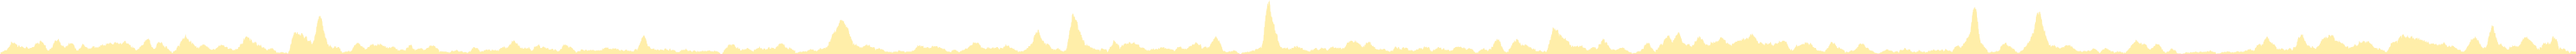

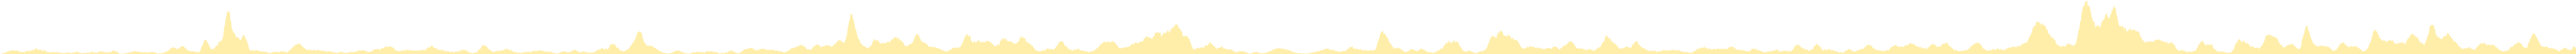

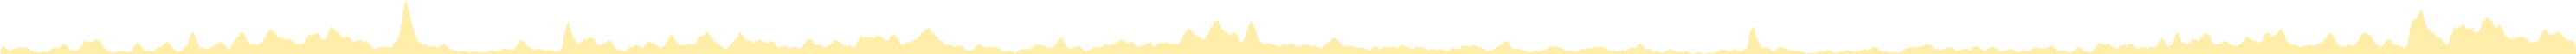

In [54]:
npoint = 10000
average_radius = 5 # seconds
resolution = [3840, 82] # pixels
nsegment = 3
# color = "#f8a8b5"
# alpha = 1.0
color = "#ffeea9"
alpha = 1.0
save_dir = "/mnt/c/Users/yiguo/Desktop/apixC_末日合集/progress_bar/"


duration_sec = 0
for num_str in duration.split(":"):
        duration_sec *= 60
        duration_sec += int(num_str)
print(f"Segment duration = {duration_sec / nsegment:.3f} sec")

for iseg in range(nsegment):
    xmin = duration_sec / nsegment * iseg
    xmax = duration_sec / nsegment * (iseg + 1)
    xstep = (xmax - xmin) / (npoint - 1)
    x_list = [xmin + xstep * _ for _ in range(npoint)]

    xmin_index = bisect_left(sec_list, xmin)
    xmax_index = bisect_right(sec_list, xmax)
    working_list = [-float('inf')] + sec_list[xmin_index: xmax_index] + [float('inf')]
    hi, lo = 0, 0
    y_list = []
    for x in x_list:
        left = x - average_radius
        right = x + average_radius
        while working_list[lo] < left:
            lo += 1
        while working_list[hi] < right:
            hi += 1
        y_list.append(hi - lo)

    dpi = 1
    figsize = tuple(_ / dpi for _ in resolution)
    plt.figure(figsize=figsize, dpi=dpi)
    plt.fill_between(x_list, y_list, [0] * len(x_list), color=color, alpha=alpha)
    plt.xlim([xmin, xmax])
    plt.ylim([0, max(y_list)])
    plt.axis('off')
    plt.savefig(save_dir + "hotspot_" + start_time + "_" + color + "_part" + str(iseg + 1) + ".png", bbox_inches='tight')
    plt.show()